<a href="https://colab.research.google.com/github/ilsilfverskiold/huggingface-cook-book/blob/main/preprocess/huggingface/BART_summarization_keywords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies
!pip install transformers datasets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# Import dataset from hugging face
dataset = load_dataset("sunhaozhepy/ag_news_keywords_embeddings")
# Check the dataset
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings'],
        num_rows: 7600
    })
})

In [ ]:
# Create a validate set (as it is missing in this dataset)
# Standard practice seems to be around 70-80% training, 10-20% validation and 10-20% testing but this is a larger dataset so we can keep the sets smaller
from datasets import DatasetDict

# Remember that the test and validation sets should be unique so we're grabbing data only from the training set to build the validation set
shuffled_training_set = dataset['train'].shuffle(seed=42)
validation_set = shuffled_training_set.select(range(7600))

new_training_set = shuffled_training_set.select(range(7600, len(shuffled_training_set)))

new_dataset = DatasetDict({
    'train': new_training_set,
    'validation': validation_set,
    'test': dataset['test']  # unchanged
})

new_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings'],
        num_rows: 112400
    })
    validation: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings'],
        num_rows: 7600
    })
    test: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings'],
        num_rows: 7600
    })
})

In [ ]:
# map out some examples from the dataset
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Text: {example['text']}'")
        print(f"'>> Keywords: {example['keywords']}'")


show_samples(new_dataset)


'>> Text: Genes, Biology Important in Obesity Fight (AP) AP - Apart from upbringing and environment, scientists are discovering that genes and biology are more important in the fight against obesity than previously believed.'
'>> Keywords: Genes, Biology, Obesity'

'>> Text: Fear of disease leads to panic in storm-ravaged Haiti Survivors of the storm that ravaged Haiti face a new menace as contaminated water, putrefying bodies and devastated sanitary systems threaten an outbreak of waterborne diseases such as malaria and tetanus, aid workers warned yesterday.'
'>> Keywords: Fear, Disease, Haiti'

'>> Text: Langer fills out a strong team for the Ryder Cup Well, it #39;s not quite great, but it might be good enough to do the job. With the conclusion of the BMW International Open on Sunday came also the final reckoning in the constitution of the Europe Ryder Cup team.'
'>> Keywords: Ryder Cup team, BMW International Open, Europe'


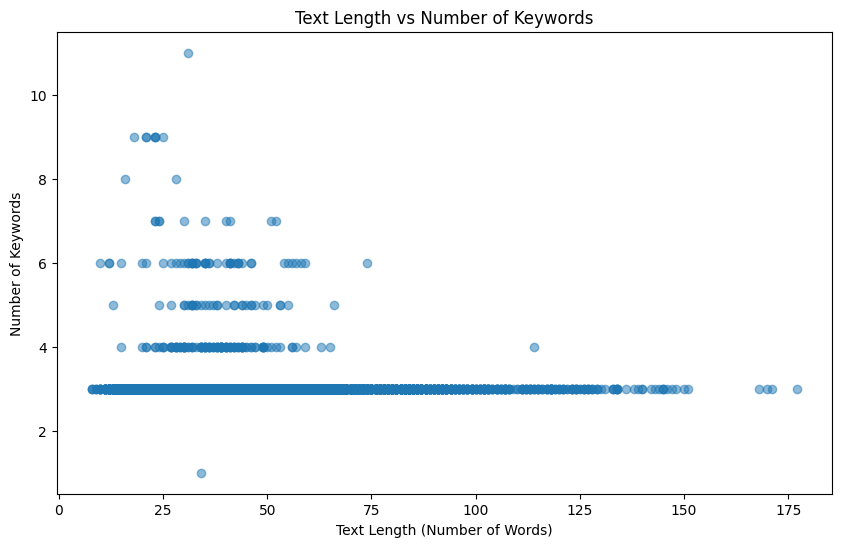

In [ ]:
# map out the distribution of text length and then keyword length
import matplotlib.pyplot as plt

train_data = new_dataset['train']

# Extract lengths of text and count of distinct keywords
text_lengths = [len(entry['text'].split()) for entry in train_data]
keyword_counts = [len(entry['keywords'].split(', ')) for entry in train_data]  # Splitting keywords by comma and space

plt.figure(figsize=(10, 6))
plt.scatter(text_lengths, keyword_counts, alpha=0.5)
plt.title("Text Length vs Number of Keywords")
plt.xlabel("Text Length (Number of Words)")
plt.ylabel("Number of Keywords")
plt.show()

In [ ]:
# understand how many tokens the longest text has (max tokens for BART is 1024)
from transformers import BartTokenizer

# Initialize the tokenizer for BART
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

texts = new_dataset['train']['text']

# Tokenize all texts and find the maximum length
max_token_length = max(len(tokenizer.encode(text, truncation=True)) for text in texts)
print(f"The longest text is {max_token_length} tokens long.")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

The longest text is 362 tokens long.


In [ ]:
# Create a function that filters out any rows with more than 5 keywords
def filter_keywords(example):
    # Split keywords by comma and space and count them
    return len(example['keywords'].split(', ')) <= 5

# Apply the filter function to all splits of the dataset
new_dataset = new_dataset.filter(filter_keywords)

new_dataset

Filter:   0%|          | 0/112334 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7594 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings'],
        num_rows: 112334
    })
    validation: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings'],
        num_rows: 7600
    })
    test: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings'],
        num_rows: 7594
    })
})

In [ ]:
# convert both the input text and the target text into a format suitable for training a sequence-to-sequence model
# remember data preprocessing functions would look different if you were using a model with a different architecture, such as an encoder-only or decoder-only model.
def get_feature(batch):
  encodings = tokenizer(batch['text'], text_target=batch['keywords'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [ ]:
# set the tokens for the entire dataset using the get_feature function
dataset_pt = new_dataset.map(get_feature, batched=True)

# if we log this now it should show us a few more fields that are necessary for training the model
dataset_pt

Map:   0%|          | 0/112334 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/7594 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 112334
    })
    validation: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7600
    })
    test: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7594
    })
})

In [ ]:
# the dataset should be formatted as PyTorch tensors with only the new fields
# i.e. specifies which columns should be returned when accessing the data - only the new fields will be returned
columns = ['input_ids', 'labels', 'attention_mask']
dataset_pt.set_format(type='torch', columns=columns)

dataset_pt

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 112334
    })
    validation: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7600
    })
    test: Dataset({
        features: ['text', 'label', 'keywords', 'keywords_embeddings', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7594
    })
})

In [ ]:
# continue to train dataset